# Packages and lib imports

In [97]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager
import torchviz

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [99]:
# /data/yarcoh/thesis_data/data/test_models/unet_v3_channel2_noiseless_b1_mu019_v1
model_name = 'unet_v3_channel2_noiseless_b1_mu038_noreg_v1'
trained_model_path = '/data/yarcoh/thesis_data/data/test_models/'+model_name
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/noiseless/1000samples_20mu'
ds_subdir = 'mu=0.19'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [100]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [101]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.05,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.38421052631578945,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': False,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'b1',
 'N_sc': 256,
 'T_guardband': 4750.0880922277665,
 'N_sc_raw': 237.50440461138834,
 'L': 960,
 'T0': 5120.0,
 'Tb': 10240.0,
 'Tn': 1358.1221810508403,
 'Zn': 87833.13612677579,
 'Pn': 8.964743939765935e-06,
 'Ns': 4096,
 'Nnft': 16384,
 'Tnft': 68266.66666666667,
 'dt': 4.166666666666667,
 'Nb': 2458,
 'T1': -25.132741228718345,
 'T2': 25.12967326714258,
 'XI': array([-511.9375,  512.    ])}

In [102]:
trainer.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 4096]             224
              Tanh-2             [-1, 32, 4096]               0
         MaxPool1d-3             [-1, 32, 2048]               0
            Conv1d-4             [-1, 64, 2048]           6,208
              Tanh-5             [-1, 64, 2048]               0
         MaxPool1d-6             [-1, 64, 1024]               0
            Conv1d-7            [-1, 128, 1024]          24,704
              Tanh-8            [-1, 128, 1024]               0
   ConvTranspose1d-9             [-1, 64, 1024]          24,640
             Tanh-10             [-1, 64, 1024]               0
  ConvTranspose1d-11             [-1, 32, 2048]           4,128
             Tanh-12             [-1, 32, 2048]               0
  ConvTranspose1d-13              [-1, 2, 4096]             130
Total params: 60,034
Trainable params: 

saved model architecture to /data/yarcoh/thesis_data/data/test_models/unet_v3_channel2_noiseless_b1_mu038_noreg_v1/_analyze/architecture.png


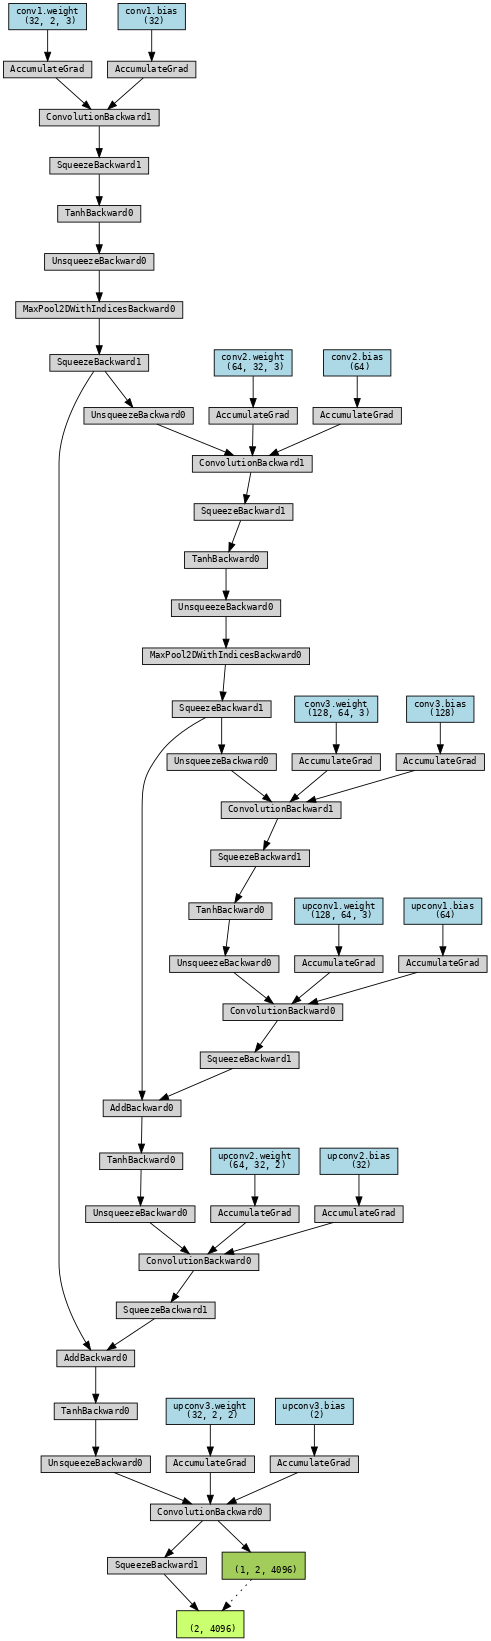

In [103]:
from IPython.display import Image
path = f'{trained_model_path}/_analyze/architecture'
trainer.plot_architecture(path)

# Replace 'image_path' with the path to your image file
Image(filename=path+'.png')


In [104]:
# for broken models with old config

# inp = input('Do you want to refresh config? (y/n) ')
# if inp == 'y':
#     trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
#     trainer.save(trained_model_path)
# else:
#         print('config not refreshed')

In [105]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [106]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [107]:
print(len(trainer.val_dataset))

300


In [108]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [109]:
print(ma.cs_in.channel_config.io_type)

b1


In [110]:
# ma.plot_single_item(1)
# N = ma.cs_in.channel_config.Ns
# N = ma.cs_in.channel_config.N_sc
# ma.cs_in.channel_config.io_type
# ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

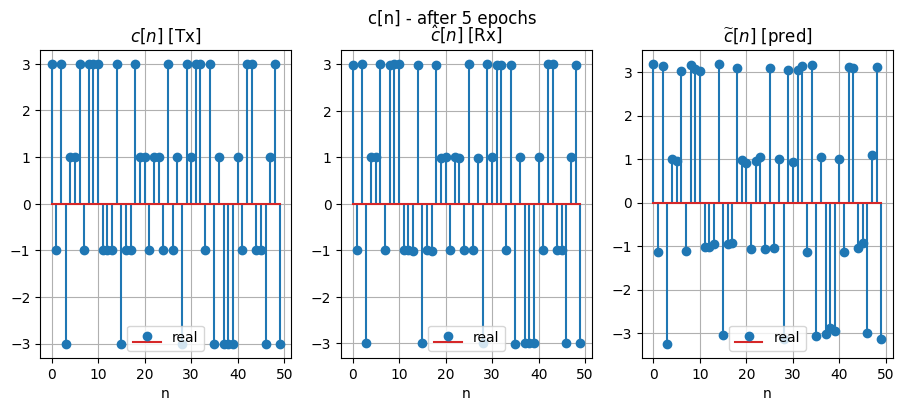

In [111]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/40 [00:00<?, ?it/s]

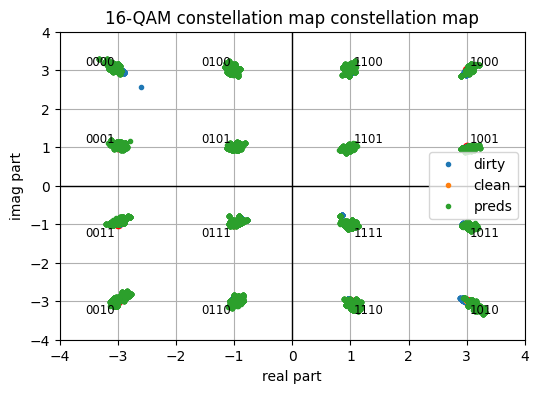

In [112]:
ma.plot_constelation(range(0,40))

In [113]:
# x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
# print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [114]:
# ma.upload_single_item_plots_to_wandb(1)

In [115]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=1000)

  0%|          | 0/300 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.0


  0%|          | 0/300 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.0
the ber improvement is 0.00%


In [116]:
ma.upload_bers_to_wandb()

the original avg ber (of validation set) is 0.0
the trained avg ber (of validation set) is 0.0
the ber improvement is 0.00%


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


ber_improvement,███████▁▁▁▃▅▆▇▇██████
model_ber,▁▁▁▁▁▁▁▁▂▃▄▅▆▆▆▇▇▇███
mu,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
org_ber,▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇███
ber_improvement,-0.0015
model_ber,0.35517
mu,1.0
org_ber,0.35464


# test all BERs

In [117]:
# add powers

# from apps.deep.power_adder import PowerAdder


# power_adder = PowerAdder(is_overright=True, verbose_level=2)
# power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.100 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.150 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.190 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.240 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.290 | org_ber=0.00e+00 | model_ber=0.00e+00 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.340 | org_ber=0.00e+00 | model_ber=1.82e-04 |  ber_improve=000%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.380 | org_ber=2.24e-03 | model_ber=7.70e-03 |  ber_improve=-243%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.430 | org_ber=1.06e-02 | model_ber=6.06e-02 |  ber_improve=-474%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.480 | org_ber=3.46e-02 | model_ber=1.23e-01 |  ber_improve=-256%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.530 | org_ber=6.93e-02 | model_ber=1.98e-01 |  ber_improve=-185%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.570 | org_ber=1.19e-01 | model_ber=2.22e-01 |  ber_improve=-87%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.620 | org_ber=1.71e-01 | model_ber=2.47e-01 |  ber_improve=-45%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.670 | org_ber=2.14e-01 | model_ber=2.66e-01 |  ber_improve=-25%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.720 | org_ber=2.41e-01 | model_ber=2.79e-01 |  ber_improve=-16%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.760 | org_ber=2.74e-01 | model_ber=2.97e-01 |  ber_improve=-08%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.810 | org_ber=3.02e-01 | model_ber=3.15e-01 |  ber_improve=-04%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.860 | org_ber=3.21e-01 | model_ber=3.28e-01 |  ber_improve=-02%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.910 | org_ber=3.36e-01 | model_ber=3.39e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=0.950 | org_ber=3.53e-01 | model_ber=3.55e-01 |  ber_improve=-01%


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

mu=1.000 | org_ber=3.55e-01 | model_ber=3.55e-01 |  ber_improve=-00%


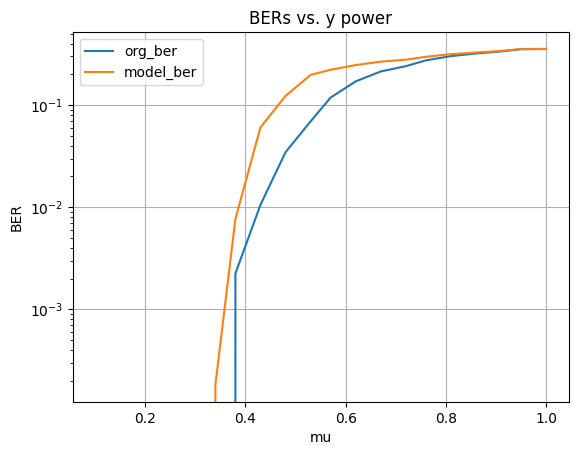

In [118]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)
                    

In [119]:
# upload to wandb
ma.upload_all_bers_to_wandb(base_path=main_ds_path,
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.1 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.15 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.19 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.24 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.29 ----------------
org_ber=0.0, model_ber=0.0, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.34 ----------------
org_ber=0.0, model_ber=0.000181640625, ber_improvement=0




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.38 ----------------
org_ber=0.002244140625, model_ber=0.0076953125, ber_improvement=-2.4290687554395127




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.43 ----------------
org_ber=0.01055859375, model_ber=0.060634765625, ber_improvement=-4.74269330373659




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.48 ----------------
org_ber=0.03458203125, model_ber=0.123041015625, ber_improvement=-2.557946458827516




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.53 ----------------
org_ber=0.06926953125, model_ber=0.197564453125, ber_improvement=-1.8521118818022897




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.57 ----------------
org_ber=0.1185625, model_ber=0.22223828125, ber_improvement=-0.8744399051133368




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.62 ----------------
org_ber=0.170791015625, model_ber=0.2468515625, ber_improvement=-0.44534278689461965




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.67 ----------------
org_ber=0.213701171875, model_ber=0.2664296875, ber_improvement=-0.24673947813371108




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.72 ----------------
org_ber=0.240634765625, model_ber=0.278728515625, ber_improvement=-0.15830526358508182




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.76 ----------------
org_ber=0.27438671875, model_ber=0.297439453125, ber_improvement=-0.08401548908788063




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.81 ----------------
org_ber=0.301916015625, model_ber=0.31544140625, ber_improvement=-0.04479851986984178




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.86 ----------------
org_ber=0.320705078125, model_ber=0.327509765625, ber_improvement=-0.0212178975767505




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.91 ----------------
org_ber=0.33551953125, model_ber=0.3393828125, ber_improvement=-0.01151432596369907




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=0.95 ----------------
org_ber=0.352740234375, model_ber=0.35487890625, ber_improvement=-0.0060630222089334




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


----------------- BERs for mu=1.0 ----------------
org_ber=0.35463671875, model_ber=0.35526171875, ber_improvement=-0.0017623668586911846




# THE END

In [120]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [121]:
# analyze on the whole dataset

# attach new dataset to trainer


In [122]:
# trainer.params

In [123]:
# ma = ModelAnalyzer(trainer)

In [124]:
# ma.plot_single_item(i=0)

In [125]:
# ma.plot_bers(_tqdm=tqdm)